In [3]:
# general imports
import pandas as pd
import numpy as np
import re
import json

# text processing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, display
from palettable.colorbrewer.qualitative import Pastel1_7
from scipy import stats


In [41]:
# Reading the file
full_df_original = pd.read_json('dataframesunified_data.json')
full_df_original.head(5)

,Beans and Rice,Cheese and Bread,Chemical Components,Dipping,Drinks,Fish,Fruits,Herbes,Irrelevant,Meat and Chicken,...,month,name,prep_time,protein,rating,review,servings,sodium,totalcarbs,year
0,0,2,0,0,0,0,0,0,3,1,...,12,Slow Cooker Reuben Dip,4,17.0,4,"[I, always, looking, great, crockpot, recipes,...",12.0,636.0,5.0,2005
1,0,2,0,0,0,0,0,0,3,1,...,2,Slow Cooker Reuben Dip,4,17.0,4,"[Enjoyed, recipe, I, chopped, sauerkraut, w, k...",12.0,636.0,5.0,2008
10,0,0,4,0,0,0,0,0,1,0,...,1,Biscotti,15,1.0,4,"[This, absolutely, bestcrispy, crunchy, mild, ...",42.0,40.0,12.0,2006
100,0,1,3,0,0,0,0,0,1,0,...,3,Cream Cheese Cut-Outs II,30,0.0,4,"[I, loved, recipe, I, looked, reviews, first, ...",48.0,24.0,8.0,2004
1000,0,1,0,0,0,0,0,0,5,1,...,12,Ham and Cheese Breakfast Quiche,20,17.0,4,"[good, breakfast, split, recipe, two, separate...",5.0,663.0,25.0,2003


In [16]:
# Checking columns
full_df_original.columns

Index(['Beans and Rice', 'Cheese and Bread', 'Chemical Components', 'Dipping',
       'Drinks', 'Fish', 'Fruits', 'Herbes', 'Irrelevant', 'Meat and Chicken',
       'Pasta', 'Pastry', 'Sauces', 'Spices', 'Starch', 'Sushi', 'Vegtables',
       'calories', 'cholesterol', 'cook_time', 'day', 'fat', 'fiber', 'month',
       'name', 'prep_time', 'protein', 'rating', 'review', 'servings',
       'sodium', 'totalcarbs', 'year'],
      dtype='object')

In [24]:
# Dropping duplicates
full_set = full_df_original.copy()
full_set = full_set.drop_duplicates(subset='name')
full_set = full_set.drop('name', axis=1)
full_set['total_time'] = full_set['prep_time'] + full_set['cook_time']

In [18]:
# Nutrition distribution 
nutrition_fact_all_recipe = full_set[['protein', 'fat','cholesterol','sodium','totalcarbs','fiber']].copy()
nutrition_fact_all_recipe['sodium'] = full_set['sodium'].apply(lambda x: x*0.001)
nutrition_fact_all_recipe['cholesterol'] = full_set['cholesterol'].apply(lambda x: x*0.001)

nutrition_fact_all_recipe = nutrition_fact_all_recipe[~(nutrition_fact_all_recipe < 0)]
nutrition_fact_all_recipe = nutrition_fact_all_recipe.dropna()

# Remove outliers with Z-score
numeric_cols = nutrition_fact_all_recipe.select_dtypes(include=[np.number]).columns
z = nutrition_fact_all_recipe[numeric_cols].apply(stats.zscore)

nutrition_fact_all_recipe = nutrition_fact_all_recipe[(z < 1).all(axis=1)]
nutrition_fact_all_recipe.head()

,protein,fat,cholesterol,sodium,totalcarbs,fiber
0,17.0,22.0,0.076,0.636,5.0,1.0
10,1.0,3.0,0.015,0.040,12.0,0.0
100,0.0,2.0,0.011,0.024,8.0,0.0
1000,17.0,32.0,0.186,0.663,25.0,1.0
10000,12.0,2.0,0.000,1.086,73.0,10.0


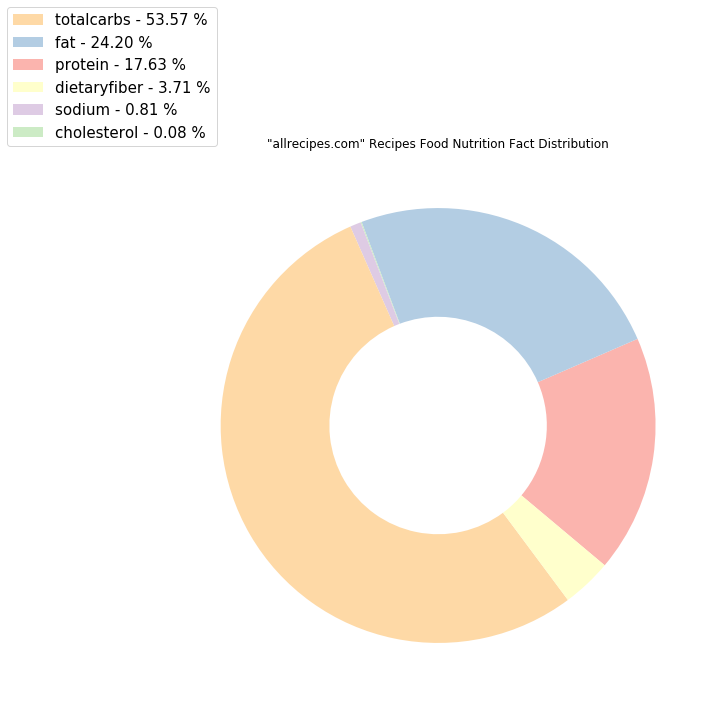

In [19]:
# Donut Plot of food nutrition facts with proportions of each nutrition fact of all repices on allrecipe.com
from palettable.colorbrewer.qualitative import Pastel1_7

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))

names = 'protein', 'fat', 'cholesterol', 'sodium', 'totalcarbs', 'dietaryfiber'
s = nutrition_fact_all_recipe.mean()

percent = 100.*s/s.sum()

patches, texts = plt.pie(s, wedgeprops=dict(width=0.5), startangle=-40, textprops={'fontsize': 14}, colors=Pastel1_7.hex_colors)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(names, percent)]
sort_legend = True

if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, s),
                                          key=lambda x: x[2],
                                          reverse=True))
plt.legend(patches, labels, loc='lower center', bbox_to_anchor=(-0.1, 1.),
           fontsize=15)

ax.set_title('"allrecipes.com" Recipes Food Nutrition Fact Distribution')

plt.show()

We can see that the highest nutrition component by quantity and on average is Carbohydrates with over 50% of the composition. Fat and protein follow with about 24% and 17% of the total composition respectively. Cholesterol and sodium, as expected, are at the bottom of the chart due to their presence being very low. In fact, for these last two, it is usually measured in milligrams, rather than in grams.

#### Nutrition Items vs Average Grams

Text(0,0.5,'Average Grams')

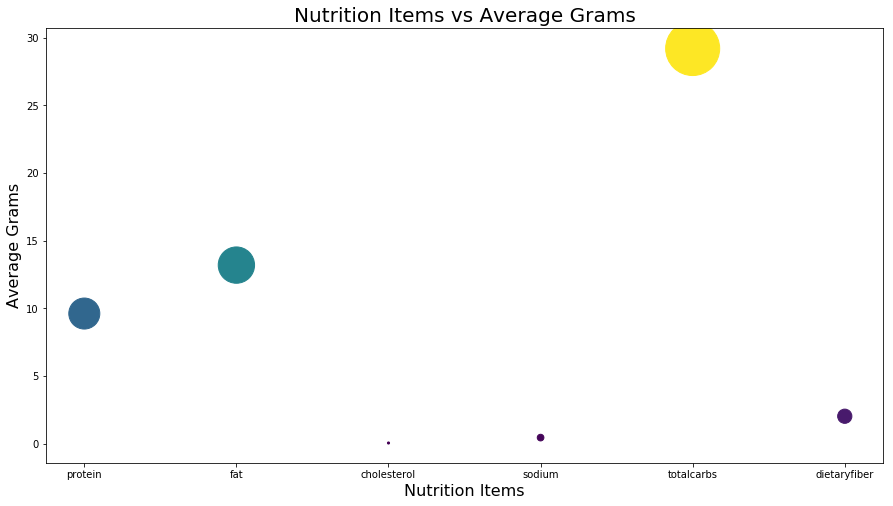

In [20]:
# Scatterplot
#set size of plot
plt.figure(figsize=(15,8))
#create plot
plt.scatter(names, s, s=s*100 , c=s)

#assign labels and title
plt.title('Nutrition Items vs Average Grams', fontsize=20)
plt.xlabel('Nutrition Items', fontsize=16)
plt.ylabel('Average Grams', fontsize=16)

A scatteplot is shown above as another way to visualize the distribution of the nutrition components by showing the average gram quantity in all the recipes.

#### Time vs Ratings

In [34]:
from scipy import stats
# Select only prep and cooking times
prep_time_all_recipe = full_set[['total_time', 'rating']].copy()

# Remove negative and null cols
prep_time_all_recipe = prep_time_all_recipe[~(prep_time_all_recipe < 0)]
prep_time_all_recipe = prep_time_all_recipe.dropna()
prep_time_all_recipe['total_time'] = prep_time_all_recipe['total_time']/60

# Remove outliers with Z-score
numeric_cols = prep_time_all_recipe.select_dtypes(include=[np.number]).columns
z = prep_time_all_recipe[numeric_cols].apply(stats.zscore)

prep_time = prep_time_all_recipe[(z < 2).all(axis=1)]

Text(0,0.5,'Ratings')

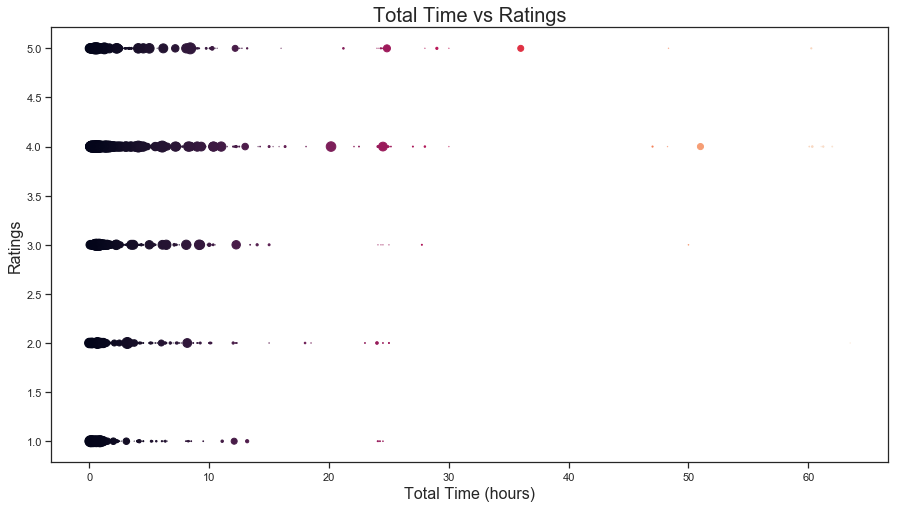

In [35]:
# Scatterplot
plt.figure(figsize=(15,8))
plt.scatter(prep_time['total_time'], prep_time['rating'], s=prep_time['total_time'].value_counts()/10, c=prep_time['total_time'])

#assign labels and title
plt.title('Total Time vs Ratings', fontsize=20)
plt.xlabel('Total Time (hours)', fontsize=16)
plt.ylabel('Ratings', fontsize=16)

In this scatterplot we can see the total time to cook a recipe. We can see from the above graph that there are more recipes with longer times of preparation/cooking with high ratings that there are with lower ratings.

#### Serving size vs Ratings

In [30]:
all_recipe_servings = full_set[['rating', 'servings']].copy()
all_recipe_servings.head()

,rating,servings
0,4,12.0
10,4,42.0
100,4,48.0
1000,4,5.0
10000,4,7.0


Text(0,0.5,' Ratings')

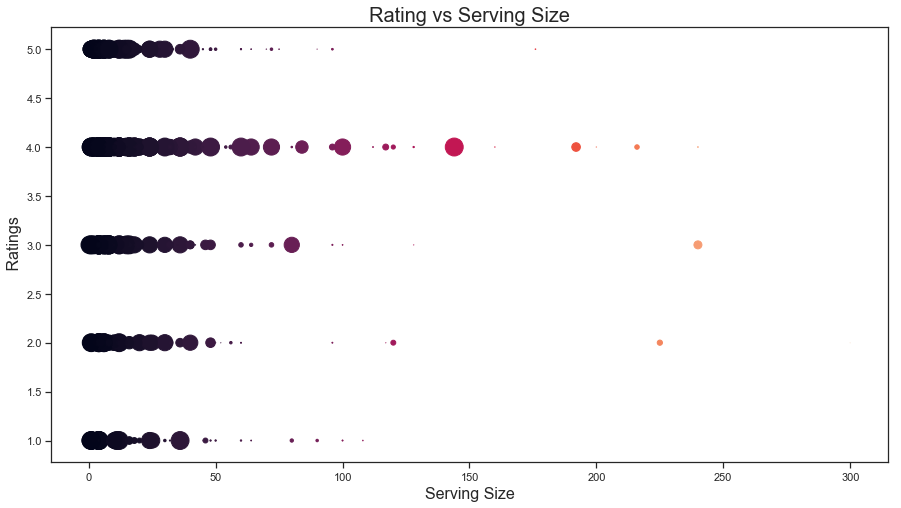

In [32]:
# Scatterplot
plt.figure(figsize=(15,8))
plt.scatter(all_recipe_servings['servings'], all_recipe_servings['rating'], s=all_recipe_servings['servings'].value_counts()/10, c=all_recipe_servings['servings'])

#assign labels and title
plt.title('Rating vs Serving Size', fontsize=20)
plt.xlabel('Serving Size', fontsize=16)
plt.ylabel(' Ratings', fontsize=16)

By plotting the ratings vs the serving size we can notice that the lower the rating the smaller is the range of serving portions. The recipes with 4 ratings show an intense density until around 85 serving portions. These portions are quite large and it can be taken as more valuable due to the greater number of people that possibly tasted the food and liked it.

#### Years vs Ratings

In [38]:
all_recipe_years = full_set[['rating', 'year']].copy()
all_recipe_years.head()

,rating,year
0,4,2005
10,4,2006
100,4,2004
1000,4,2003
10000,4,2004


Text(0,0.5,'Year')

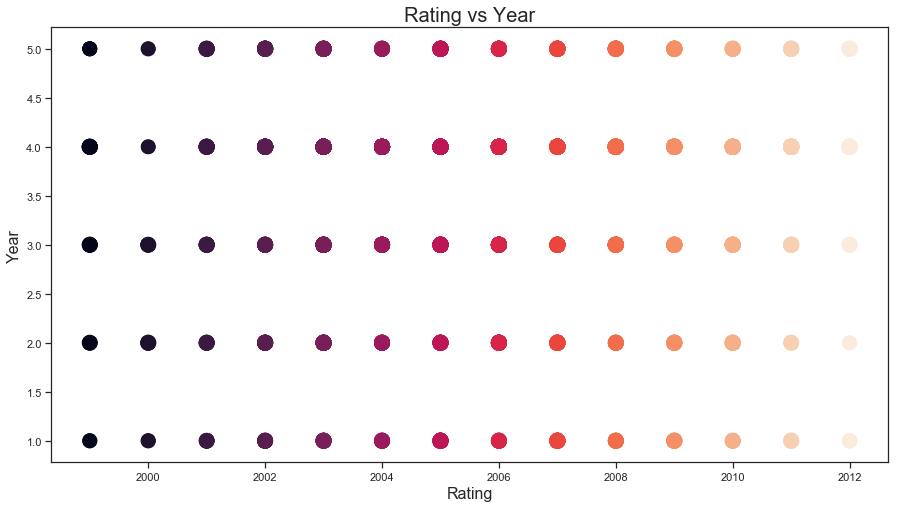

In [39]:
# Scatterplot
plt.figure(figsize=(15,8))
plt.scatter(all_recipe_years['year'], all_recipe_years['rating'], s=all_recipe_years['year'].value_counts()/10, c=all_recipe_years['year'])

#assign labels and title
plt.title('Rating vs Year', fontsize=20)
plt.xlabel('Rating', fontsize=16)
plt.ylabel('Year', fontsize=16)

From the above graph we can see that the distribution between ratings and years of the recipes is quite consistent throughout the years. 